# Fake News Challenge

**Data preprocessing and Feature Engineering**

This [Fake News Challenge](http://www.fakenewschallenge.org/) was launched in 2017 as the first part of a series of ML challenges meant to build an AI pipeline.  This first part (FNC-1) is meant to perform **Stance Detection**; the idea being to look for consensus views and outliers. 

In [1]:
import os
import sys

import pandas as pd
#pd.set_option('display.max_rows', None)
# pd.options.display.float_format = '{:, .2f}'.format
pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns', 100)

import numpy as np
from numpy import save, load
from numpy import savez_compressed
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
import copy
import pickle

#from scipy.misc import comb, logsumexp
from sklearn.manifold import TSNE #a tool to visualize high dimensional data
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD # dimensionality reduction using truncated SVD (AKA LSA)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from nltk.collocations import *
import string #python module
import re # python regex module
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize

import gensim
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

np.random.seed(0)

from sklearn.preprocessing import normalize
from functools import reduce

In [2]:
nltk.download('punkt') # a sentance tokenizer
nltk.download('gutenberg') # a text corpora and lexical resources
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/gavisar_matthew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/gavisar_matthew/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gavisar_matthew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Getting familiar with the data

Read data into pandas for visual inspection, look for nan values, get some basic counts, edit column and data types names as necessary

In [3]:
# Alias csv file paths for the 4 datasets provided
Train_Bodies = 'train_bodies.csv'
Train_Stances = 'train_stances.csv'

Test_Bodies = 'competition_test_bodies.csv'
Test_Stances = 'competition_test_stances.csv'

# read in bodies data to pandas and inspect
TrainBodies_df = pd.read_csv(Train_Bodies)
# rename Body ID column for uniformity and incase we use dot instad of bracket notation when working with the data
TrainBodies_df.rename(columns = {'Body ID':'Body_ID'}, inplace=True)
# inspect df: look for nan values, data types and view a small sample
print(TrainBodies_df.isna().sum())
print()
print(TrainBodies_df.info())
print()
print("TrainBodies_df")
TrainBodies_df.head()

Body_ID        0
articleBody    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
Body_ID        1683 non-null int64
articleBody    1683 non-null object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB
None

TrainBodies_df


,Body_ID,articleBody
0,0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \r\n\r\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized ..."
1,4,"Last week we hinted at what was to come as Ebola fears spread across America. Today, we get confirmation. As The Daily Caller reports, one passenger at Dulles International Airport outside Washington, D.C. is apparently not taking any chances. A female passenger dressed in a hazmat suit - complete with a full body gown, mask and gloves - was spotted Wednesday waiting for a flight at the airport.\r\n\r\n \r\n\r\n\r\n\r\nSource: The Daily Caller\r\n\r\nWe particularly liked the JCPenney bag - ..."
2,5,"(NEWSER) – Wonder how long a Quarter Pounder with cheese can last? Two Australians say they bought a few McDonald's burgers for friends back in 1995, when they were teens, and one of the friends never showed up. So the kid's burger went uneaten—and stayed that way, Australia's News Network reports. ""We’re pretty sure it’s the oldest burger in the world,"" says one of the men, Casey Dean. Holding onto the burger for their friend ""started off as a joke,"" he adds, but ""the months became years an..."
3,6,"Posting photos of a gun-toting child online, ISIS supporters announced that the group’s youngest soldier has died in combat.\r\n\r\nTwitter accounts linked to the Islamic State of Iraq and Al-Sham claimed that the child soldier “got martyred” with his father while fighting for the terrorist group in Syria.\r\n\r\nPhotos posted on Twitter showed the smiling boy in military fatigues holding weapons that, at times, are almost as large as his body. British media reported that the child was rough..."
4,7,"At least 25 suspected Boko Haram insurgents were killed in clashes between soldiers and the Islamist militants in northeast Nigeria and five civilians were killed in fighting elsewhere in the region, a military source and residents said on Monday.\r\n\r\nA ceasefire agreement between Boko Haram and the Nigerian government was expected to lead to the liberation of more than 200 schoolgirls kidnapped by the militants six months ago, and talks were due to continue in neighbouring Chad on Monday..."


In [4]:
# read in Stances dataset and inspect
TrainStances_df = pd.read_csv(Train_Stances)
# rename Body ID column for uniformity and incase we use dot instad of bracket notation when working with the data
TrainStances_df.rename(columns={'Body ID':'Body_ID'}, inplace=True)
# inspect df: look for nan values, data types and view a small sample
print(TrainStances_df.isna().sum())
print()
print(TrainStances_df.info())
print()
print("There are {} unique Body_ID values in the Train Stances dataset".format(TrainStances_df['Body_ID'].nunique()))
print()
display(TrainStances_df.head())

Headline    0
Body_ID     0
Stance      0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
Headline    49972 non-null object
Body_ID     49972 non-null int64
Stance      49972 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None

There are 1683 unique Body_ID values in the Train Stances dataset



,Headline,Body_ID,Stance
0,Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza as Israel opens dams,158,agree
2,"Christian Bale passes on role of Steve Jobs, actor reportedly felt he wasn't right for part",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV Streaming Service Launching in April,1034,unrelated
4,Spider burrowed through tourist's stomach and up into his chest,1923,disagree


In [5]:
print("Number of unique Headlines: %s" % TrainStances_df.Headline.nunique())
print("Number of unique Body_IDs: %s" % TrainStances_df.Body_ID.nunique())

Number of unique Headlines: 1648
Number of unique Body_IDs: 1683


In [6]:
TestBodies_df = pd.read_csv(Test_Bodies)
TestBodies_df.rename(columns = {'Body ID':'Body_ID'}, inplace=True)
print()
print(TestBodies_df.isna().sum())
print()
print(TestBodies_df.info())
print()
display(TestBodies_df.head(1))


Body_ID        0
articleBody    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 2 columns):
Body_ID        904 non-null int64
articleBody    904 non-null object
dtypes: int64(1), object(1)
memory usage: 14.2+ KB
None



,Body_ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating that he offered to extend the Gaza Strip.


In [7]:
TestStances_df = pd.read_csv(Test_Stances)
TestStances_df.rename(columns = {'Body ID':'Body_ID'}, inplace=True)
print(TestStances_df.isna().sum())
print()
print(TestStances_df.info())
print()
display(TestStances_df.head(1))

Headline    0
Body_ID     0
Stance      0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25413 entries, 0 to 25412
Data columns (total 3 columns):
Headline    25413 non-null object
Body_ID     25413 non-null int64
Stance      25413 non-null object
dtypes: int64(1), object(2)
memory usage: 595.7+ KB
None



,Headline,Body_ID,Stance
0,Ferguson riots: Pregnant woman loses eye after cops fire BEAN BAG round through car window,2008,unrelated


(array([0.00035122, 0.00027922, 0.00038102, 0.00034443, 0.00034727,
        0.00042069, 0.00038213, 0.00049886, 0.00046566, 0.00047894]),
 array([   0. ,  253.2,  506.4,  759.6, 1012.8, 1266. , 1519.2, 1772.4,
        2025.6, 2278.8, 2532. ]),
 <a list of 10 Patch objects>)

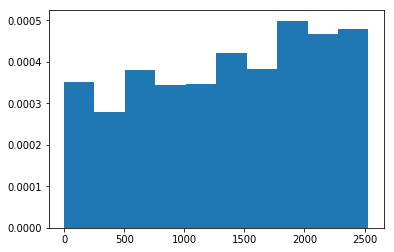

In [8]:
# is there anything to note about the distribution of body_ID?
# instantiate a figure with axes object
fig, ax = plt.subplots()
#alias data we will view
x = TrainStances_df['Body_ID']
# add to axis object within the figure
ax.hist(x, density=True )

# Preprocessing

Preparing text data for machine learning (in this instance) means:
 - keeping only data that have value - remove punctuation and stop words
 - lower case all text so the same word spelled with a capital does not result in a distinction/duplicate
 - tokenizing the corpus as preparation for feature engineering

In [9]:
# join TrainBodies_df and TrainStances_df

df_train = TrainStances_df.merge(TrainBodies_df, how = 'left', on = 'Body_ID', validate= 'm:1')
df_test = TestStances_df.merge(TestBodies_df, how = 'left', on = 'Body_ID', validate= 'm:1')

print("df_train shape:" + str(df_train.shape))
print("df_test shape:" + str(df_test.shape))
#(not suing f strings here since GCE (Google Compute Engine) py3 kernal does not support them)

df_train shape:(49972, 4)
df_test shape:(25413, 4)


In [10]:
# stack train and test sets
objs = [df_train, df_test]
data = pd.concat(objs, axis = 0, join='outer')
print(data.shape)

(75385, 4)


In [11]:
# replace target lables with numeric target values, ie, label encode
df_1 = copy.deepcopy(data)
df_1.Stance.replace({'agree':0, 'disagree':1, 'discuss':2, 'unrelated':3}, inplace=True)

# lowercase all text
df_2 = copy.deepcopy(df_1)
df_2['Headline'] = df_2['Headline'].str.lower()
df_2['articleBody'] = df_2['articleBody'].str.lower()

# remove punctuation/ keep what you want
tokenizer = RegexpTokenizer (r"(?u)\b\w\w+\b")
df_2['Headline_tokens'] = df_2['Headline'].map(tokenizer.tokenize)
df_2['articleBody_tokens'] = df_2['articleBody'].map(tokenizer.tokenize)
df_2.head(3)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens
0,police find mass graves with at least '15 bodies' near mexico town where 43 students disappeared after police clash,712,3,"danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-founder steve wozniak in sony’s steve jobs biopic.\r\n\r\ndanny boyle is directing the untitled film, based on walter isaacson's book and adapted by aaron sorkin, which is one of the most anticipated biopics in recent years.\r\n\r\nnegotiations have not yet begun, and it’s not even clear if rogen has an official offer, but the producers — scott rudin, guymon casady and mark gordon — have set their sig...","[police, find, mass, graves, with, at, least, 15, bodies, near, mexico, town, where, 43, students, disappeared, after, police, clash]","[danny, boyle, is, directing, the, untitled, film, seth, rogen, is, being, eyed, to, play, apple, co, founder, steve, wozniak, in, sony, steve, jobs, biopic, danny, boyle, is, directing, the, untitled, film, based, on, walter, isaacson, book, and, adapted, by, aaron, sorkin, which, is, one, of, the, most, anticipated, biopics, in, recent, years, negotiations, have, not, yet, begun, and, it, not, even, clear, if, rogen, has, an, official, offer, but, the, producers, scott, rudin, guymon, casa..."
1,hundreds of palestinians flee floods in gaza as israel opens dams,158,0,"hundreds of palestinians were evacuated from their homes sunday morning after israeli authorities opened a number of dams near the border, flooding the gaza valley in the wake of a recent severe winter storm.\r\n\r\nthe gaza ministry of interior said in a statement that civil defense services and teams from the ministry of public works had evacuated more than 80 families from both sides of the gaza valley (wadi gaza) after their homes flooded as water levels reached more than three meters.\r...","[hundreds, of, palestinians, flee, floods, in, gaza, as, israel, opens, dams]","[hundreds, of, palestinians, were, evacuated, from, their, homes, sunday, morning, after, israeli, authorities, opened, number, of, dams, near, the, border, flooding, the, gaza, valley, in, the, wake, of, recent, severe, winter, storm, the, gaza, ministry, of, interior, said, in, statement, that, civil, defense, services, and, teams, from, the, ministry, of, public, works, had, evacuated, more, than, 80, families, from, both, sides, of, the, gaza, valley, wadi, gaza, after, their, homes, flo..."
2,"christian bale passes on role of steve jobs, actor reportedly felt he wasn't right for part",137,3,"30-year-old moscow resident was hospitalized with wounds very intimate nature. as it became known lifenews, in the hands of doctors, the man complained that his casual acquaintance opoila in the sauna, and then gently held his castration operation. and actions criminals were executed with surgical precision - woman sewed all the smallest blood vessels.\r\n\r\n\r\n\r\n- i met a girl at the bar, and then we went to the sauna for a taxi. i remember that i had a beer, and more do not remember, -...","[christian, bale, passes, on, role, of, steve, jobs, actor, reportedly, felt, he, wasn, right, for, part]","[30, year, old, moscow, resident, was, hospitalized, with, wounds, very, intimate, nature, as, it, became, known, lifenews, in, the, hands, of, doctors, the, man, complained, that, his, casual, acquaintance, opoila, in, the, sauna, and, then, gently, held, his, castration, operation, and, actions, criminals, were, executed, with, surgical, precision, woman, sewed, all, the, smallest, blood, vessels, met, girl, at, the, bar, and, then, we, went, to, the, sauna, for, taxi, remember, that, had,..."


In [12]:
# instantiate list of stop words and other characters to remove
stopwords_list = stopwords.words('english')
stopwords_list += ["''", '""', '...', '``',"_"]

# remove stop words / keep everything except stopwords_list
df_2['Headline_tokens'] = df_2['Headline_tokens'].apply(lambda x: [item for item in x if item not in stopwords_list])
df_2['articleBody_tokens'] = df_2['articleBody_tokens'].apply(lambda x: [item for item in x if item not in stopwords_list])

The highest scoring team used stemming instead of lemmatization so I decided to use stemming since it's less complicated and will save time.  Lemmatization may be included in future work. 

In [13]:
# alias stemmer method
stemmer = nltk.stem.SnowballStemmer('english')
# stem Headline_tokens and articleBody_tokens
df_2['Headline_tokens'] = df_2.apply(lambda row: [stemmer.stem(item) for item in row.Headline_tokens], axis=1)
df_2['articleBody_tokens'] = df_2.apply(lambda row: [stemmer.stem(item) for item in row.articleBody_tokens], axis=1)
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens
0,police find mass graves with at least '15 bodies' near mexico town where 43 students disappeared after police clash,712,3,"danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-founder steve wozniak in sony’s steve jobs biopic.\r\n\r\ndanny boyle is directing the untitled film, based on walter isaacson's book and adapted by aaron sorkin, which is one of the most anticipated biopics in recent years.\r\n\r\nnegotiations have not yet begun, and it’s not even clear if rogen has an official offer, but the producers — scott rudin, guymon casady and mark gordon — have set their sig...","[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, clash]","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, soni, steve, job, biopic, danni, boyl, direct, untitl, film, base, walter, isaacson, book, adapt, aaron, sorkin, one, anticip, biopic, recent, year, negoti, yet, begun, even, clear, rogen, offici, offer, produc, scott, rudin, guymon, casadi, mark, gordon, set, sight, talent, talk, cours, may, naught, christian, bale, actor, play, job, still, midst, close, deal, sourc, say, dealmak, process, sensit,..."


# Feature Engineering

We have cleaned the unstructured data and can now work on molding it into training features that will become a painting of nuances that math can evaluate and extract meaning from.

### Basic Count Features

A common approach in NLP is to look at word frequency distributions though, we will substitute those here for a set of ratios the top scoring team employed.

- count how many times an n_gram appears in Headlline or articleBody, how many unique grams there are and the ratio between the two counts
- calc how many grams that appear in Headline are also in articleBody

## Generate n-grams

The funcitons below return a list of the given n-grams instead of an iterable object that `nltk.BigramCollocationFinder` returns.  Having the grams in a list will allow us to generate counts as needed.

In [14]:
# https://github.com/Cisco-Talos/fnc-1/blob/master/tree_model/ngram.py

# create functions to build n_grams
def getUnigram(words):
    #assert type(words) == []
    return words

def getBigram(words, join_string, skip=0):
    L = len(words)
    if L > 1:
        lst = []
        for i in range(L-1):
            for k in range(1, skip+2):
                if i + k < L:
                    lst.append(join_string.join([words[i], words[i+k]]))
        return lst
    else:
        # set it as unigram
        lst = getUnigram(words)
        return lst
                    
def getTrigram(words, join_string, skip=0):
    #assert type(words) == []
    L = len(words)
    if L > 2:
        lst = []
        for i in range(L-2):
            for k1 in range(1, skip+2):
                for k2 in range(1, skip+2):
                    if i+k1 < L and i+k1+k2 < L:
                        lst.append(join_string.join([words[i], words[i+k1], words[i+k1+k2]]))
        return lst
    else:
        #set as bigram
        lst = getBigram(words, join_string, skip)
        return lst
    
def getFourgram(words, join_string):

    #assert type(words) == list
    L = len(words)
    if L > 3:
        lst = []
        for i in xrange(L-3):
            lst.append( join_string.join([words[i], words[i+1], words[i+2], words[i+3]]) )
        return lst
    else:
        # set it as bigram
        lst = getTrigram(words, join_string)
    return lst



def getBiterm(words, join_string):
    """
        Input: a list of words, e.g., ['I', 'am', 'Denny', 'boy']
        Output: a list of biterm, e.g., ['I_am', 'I_Denny', 'I_boy', 'am_Denny', 'am_boy', 'Denny_boy']
        I use _ as join_string for this example.
    """
   # assert type(words) == list
    L = len(words)
    if L > 1:
        lst = []
        for i in range(L-1):
            for j in range(i+1,L):
                lst.append( join_string.join([words[i], words[j]]) )
        return lst
    
    else:
        # set it as unigram
        lst = getUnigram(words)
    return lst
    
def getTriterm(words, join_string):
    """
        Input: a list of words, e.g., ['I', 'am', 'Denny']
        Output: a list of triterm, e.g., ['I_am_Denny', 'I_Denny_am', 'am_I_Denny',
        'am_Denny_I', 'Denny_I_am', 'Denny_am_I']
        I use _ as join_string for this example.
    """
   # assert type(words) == list
    L = len(words)
    if L > 2:
        lst = []
        for i in xrange(L-2):
            for j in xrange(i+1,L-1):
                for k in xrange(j+1,L):
                    lst.append( join_string.join([words[i], words[j], words[k]]) )
        return lst
    else:
        # set it as biterm
        lst = getBiterm(words, join_string)
    return lst

<p>&nbsp;</p>
We could create grams of greater length though, none of the top scoring teams went beyond trigrams. 
<p>&nbsp;</p>

In [15]:
# generate unigram
df_2["Headline_unigram"] = df_2["Headline_tokens"].map(lambda x: getUnigram(x))
df_2["articleBody_unigram"] = df_2["articleBody_tokens"].map(lambda x: getUnigram(x))

# generate bigram
join_str = "_"
df_2["Headline_bigram"] = df_2["Headline_unigram"].map(lambda x: getBigram(x, join_str))
df_2["articleBody_bigram"] = df_2["articleBody_unigram"].map(lambda x: getBigram(x, join_str))
        
# generate trigram
join_str = "_"
df_2["Headline_trigram"] = df_2["Headline_unigram"].map(lambda x: getTrigram(x, join_str))
df_2["articleBody_trigram"] = df_2["articleBody_unigram"].map(lambda x: getTrigram(x, join_str))

In [16]:
pd.set_option('display.max_colwidth',50)
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram
0,police find mass graves with at least '15 bodi...,712,3,danny boyle is directing the untitled film\r\n...,"[polic, find, mass, grave, least, 15, bodi, ne...","[danni, boyl, direct, untitl, film, seth, roge...","[polic, find, mass, grave, least, 15, bodi, ne...","[danni, boyl, direct, untitl, film, seth, roge...","[polic_find, find_mass, mass_grave, grave_leas...","[danni_boyl, boyl_direct, direct_untitl, untit...","[polic_find_mass, find_mass_grave, mass_grave_...","[danni_boyl_direct, boyl_direct_untitl, direct..."


In [17]:
# calc percent of text in given Headline or articleBody that is unique ( unique grams / ttl grams)

''' 
    count ttl # of n-gram
    count ttl # of unique n-gram
    divide ttl # uniqe by ttl #
    
'''

grams = ["unigram", "bigram", "trigram"]
feat_names = ["Headline", "articleBody"]

for feat_name in feat_names:
    for gram in grams:
        df_2["count_of_%s_%s" % (feat_name, gram)] = list(df_2.apply(lambda x: len(x[feat_name + "_" + gram]), axis=1))
        df_2["count_of_unique_%s_%s" % (feat_name, gram)] = \
              list(df_2.apply(lambda x: len(set(x[feat_name + "_" + gram])), axis=1))
        df_2["ratio_of_unique_%s_%s" % (feat_name, gram)] = \
            df_2["count_of_unique_%s_%s"%(feat_name,gram)] / df_2["count_of_%s_%s"%(feat_name,gram)]
            #map(try_divide, df_2["count_of_unique_%s_%s"%(feat_name,gram)], df_2["count_of_%s_%s"%(feat_name,gram)])
            
            

In [18]:
# overlapping n-grams count

for gram in grams:
    # count grams appearing in Headline that are also inside its coresponding articleBody
    df_2["count_of_Headline_%s_in_articleBody" % gram] = \
        list(df_2.apply(lambda x: sum([1. for w in x["Headline_" + gram] if w in set(x["articleBody_" + gram])]), axis=1))
    
    # return the ratio of overlapping grams to total grams to ttl Headline grams
    df_2["ratio_of_Headline_%s_in_articleBody" % gram] = \
        df_2["count_of_Headline_%s_in_articleBody" % gram] / df_2["count_of_Headline_%s" % gram]
        #map(try_divide, df["count_of_Headline_%s_in_articleBody" % gram], df["count_of_Headline_%s" % gram])
        


In [19]:
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,ratio_of_unique_Headline_unigram,count_of_Headline_bigram,count_of_unique_Headline_bigram,ratio_of_unique_Headline_bigram,count_of_Headline_trigram,count_of_unique_Headline_trigram,ratio_of_unique_Headline_trigram,count_of_articleBody_unigram,count_of_unique_articleBody_unigram,ratio_of_unique_articleBody_unigram,count_of_articleBody_bigram,count_of_unique_articleBody_bigram,ratio_of_unique_articleBody_bigram,count_of_articleBody_trigram,count_of_unique_articleBody_trigram,ratio_of_unique_articleBody_trigram,count_of_Headline_unigram_in_articleBody,ratio_of_Headline_unigram_in_articleBody,count_of_Headline_bigram_in_articleBody,ratio_of_Headline_bigram_in_articleBody,count_of_Headline_trigram_in_articleBody,ratio_of_Headline_trigram_in_articleBody
0,police find mass graves with at least '15 bodi...,712,3,danny boyle is directing the untitled film\r\n...,"[polic, find, mass, grave, least, 15, bodi, ne...","[danni, boyl, direct, untitl, film, seth, roge...","[polic, find, mass, grave, least, 15, bodi, ne...","[danni, boyl, direct, untitl, film, seth, roge...","[polic_find, find_mass, mass_grave, grave_leas...","[danni_boyl, boyl_direct, direct_untitl, untit...","[polic_find_mass, find_mass_grave, mass_grave_...","[danni_boyl_direct, boyl_direct_untitl, direct...",15,14,0.933333,14,14,1.0,13,13,1.0,114,88,0.77193,113,108,0.955752,112,109,0.973214,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# count number of sentences in headline and body
for feat_name in feat_names:
    df_2['len_sent_%s' % feat_name] = df_2[feat_name].apply(lambda x: len(sent_tokenize(x)))

In [22]:
pd.set_option('display.max_colwidth',50)
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,ratio_of_unique_Headline_unigram,count_of_Headline_bigram,count_of_unique_Headline_bigram,ratio_of_unique_Headline_bigram,count_of_Headline_trigram,count_of_unique_Headline_trigram,ratio_of_unique_Headline_trigram,count_of_articleBody_unigram,count_of_unique_articleBody_unigram,ratio_of_unique_articleBody_unigram,count_of_articleBody_bigram,count_of_unique_articleBody_bigram,ratio_of_unique_articleBody_bigram,count_of_articleBody_trigram,count_of_unique_articleBody_trigram,ratio_of_unique_articleBody_trigram,count_of_Headline_unigram_in_articleBody,ratio_of_Headline_unigram_in_articleBody,count_of_Headline_bigram_in_articleBody,ratio_of_Headline_bigram_in_articleBody,count_of_Headline_trigram_in_articleBody,ratio_of_Headline_trigram_in_articleBody,len_sent_Headline,len_sent_articleBody
0,police find mass graves with at least '15 bodi...,712,3,danny boyle is directing the untitled film\r\n...,"[polic, find, mass, grave, least, 15, bodi, ne...","[danni, boyl, direct, untitl, film, seth, roge...","[polic, find, mass, grave, least, 15, bodi, ne...","[danni, boyl, direct, untitl, film, seth, roge...","[polic_find, find_mass, mass_grave, grave_leas...","[danni_boyl, boyl_direct, direct_untitl, untit...","[polic_find_mass, find_mass_grave, mass_grave_...","[danni_boyl_direct, boyl_direct_untitl, direct...",15,14,0.933333,14,14,1.0,13,13,1.0,114,88,0.77193,113,108,0.955752,112,109,0.973214,0.0,0.0,0.0,0.0,0.0,0.0,1,9


In [23]:
# save basic count features to disk for later use

feat_names_bcf = [ n for n in df_2.columns \
                if "count" in n \
                or "ratio" in n \
                or "len_sent" in n]

xBasicCountsTrain = df_2[feat_names].values
outfilename_bcf_train = "train.basic.pkl"
with open(outfilename_bcf_train, "wb") as outfile:
    pickle.dump(feat_names, outfile, -1)
    pickle.dump(xBasicCountsTrain, outfile, -1)
print ('basic counting features for training saved in %s' % outfilename_bcf_train)

basic counting features for training saved in train.basic.pkl


# Latent Semantic Analysis

## TF-IDF

Term Frequency-Inverse Document Frequency scores words on a spectrum of more vs less rare, i.e., important, within the corpus.  The more rare words contain more information or insight than heavily used words. To that end, we will join the Headline and articleBody sets to train the tf-idf vectorizer on the entire corpus and then fit to each aforementioned set individualy.  

In [24]:
def cat_text(x):
    res = '%s %s' % (' '.join(x['Headline_unigram']), ' '.join(x['articleBody_unigram']))
    return res

# concatenate Headline and Body so we can fit a tfidf vectorizer that will learn the combined vocabulary
df_2['all_text'] = list(df_2.apply(cat_text, axis = 1))

In [25]:
# fit a TfidfVectorizer on the concatenated strings (fit learns the vocabulary and idf)

vec = TfidfVectorizer(ngram_range = (1, 3), max_df= 0.8, min_df= 2)
vec.fit(df_2['all_text'])
vocabulary = vec.vocabulary_

In [26]:
# transform Headline unigrams into tf-idf vector using the learned vocabulary
vecH = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df= 2, vocabulary=vocabulary)
xHeadlineTfidf = vecH.fit_transform(df_2['Headline_unigram'].map(lambda x: ' '.join(x)))
print ("xHeadlineTfidf.shape:" + str(xHeadlineTfidf.shape))

# save for later use
outfilename_htfidf_train = "train.headline.tfidf.pkl"
with open (outfilename_htfidf_train, 'wb') as outfile:
    pickle.dump(xHeadlineTfidf, outfile, -1)

# transform articleBody unigrams using the learned vocabulary
vecB = TfidfVectorizer(ngram_range=(1, 3), max_df=0.8, min_df=2, vocabulary=vocabulary)
xBodyTfidf = vecB.fit_transform(df_2['articleBody_unigram'].map(lambda x: ' '.join(x)))
print ("xBodyTfidf.shape:" +  str(xBodyTfidf.shape))

outfilename_btfidf_train = "train.body.tfidf.pkl"
with open(outfilename_btfidf_train, "wb") as outfile:
    pickle.dump(xBodyTfidf, outfile, -1)
    


xHeadlineTfidf.shape:(75385, 762837)
xBodyTfidf.shape:(75385, 762837)


scikit-learn has a `cosine_similarity` function though, we must consider the input shape of our data and the desired output shape.  We need to take in extremely large 2-D arrays and end up with a 2-D array of **one** feature.  To do this, we first convert each input into a Coordinate Format matrix before computing `cosine_similarity` , calculate the row-wise cosine_similarity and finally coerce it from a 1-D to 2-D array.

In [27]:
def cosine_sim(x, y):
    try:
        if type(x) is np.ndarray: x = x.reshape(1, -1)
        if type(y) is np.ndarray: y = y.reshape(1, -1)
        d = cosine_similarity(x, y)
        d = d[0][0]
    except:
        print (x)
        print (y)
        d = 0.
    return d

In [28]:
# calculate cosine similarity between Headline and articleBody

#load_xHeadlineTfidf = pickle.load(open("train.headline.tfidf.pkl", 'rb'))
#load_bodyTfidf = pickle.load(open("train.body.tfidf.pkl", 'rb'))

simTfidf_train = np.asarray(list(map(cosine_sim, xHeadlineTfidf, xBodyTfidf)))[:, np.newaxis]

print(simTfidf_train.shape)

# save for later use
outfilename_simtfidf_train = "train.sim.tfidf.pkl"
with open(outfilename_simtfidf_train, "wb") as outfile:
    pickle.dump(simTfidf_train, outfile, -1)


(75385, 1)


Applying Singular Value Decomposition (SVD) to the tf-idf features to reduce dimensionality while preserving similarity structure and find latent topics.  Take tf-idf features and apply SVD.  Then calculate cosine similarities between the SVD features of Headline and articleBody.  This similarity metric is telling of whether the body and headline are related or not. 

In [29]:
print(xHeadlineTfidf.shape)
print(type(xHeadlineTfidf))
print()
print(xBodyTfidf.shape)
print(type(xBodyTfidf))

(75385, 762837)
<class 'scipy.sparse.csr.csr_matrix'>

(75385, 762837)
<class 'scipy.sparse.csr.csr_matrix'>


## SVD

In [ ]:
from scipy.sparse import vstack
xHBTfidf = vstack((xHeadlineTfidf, xBodyTfidf)).toarray() # toarray() converts the csr_matrix objects to numpy arrays
svd = TruncatedSVD(n_components=100, n_iter=15, random_state = 42)

# fit to the combined train-test set (or t
svd.fit(xHBTfidf) 
print ('xHeadlineTfidf.shape:')
print (xHeadlineTfidf.shape)

In [34]:
# transform headline tfidf features using svd
xHeadlineSvd = svd.transform(xHeadlineTfidf)
print ('xHeadlineSvd.shape:')
print (xHeadlineSvd.shape)

# save for later use
xHeadlineSvdTrain = xHeadlineSvd
outfilename_hsvd_train = "train.headline.svd.pkl"
with open(outfilename_hsvd_train, "wb") as outfile:
    pickle.dump(xHeadlineSvdTrain, outfile, -1)

xHeadlineTfidf.shape:
(75385, 762837)
xHeadlineSvd.shape:
(75385, 100)


In [35]:
# transform articleBody tfidf features using svd
xBodySvd = svd.transform(xBodyTfidf)
print ('xBodySvd.shape:')
print (xBodySvd.shape)

# save for later use
xBodySvdTrain = xBodySvd
outfilename_bsvd_train = "train.body.svd.pkl"
with open(outfilename_bsvd_train, "wb") as outfile:
    pickle.dump(xBodySvdTrain, outfile, -1)

xBodySvd.shape:
(75385, 100)


In [36]:
# calculate cosine similarity for each record

simSvd_train = np.asarray(list(map(cosine_sim, xHeadlineSvd, xBodySvd)))[:, np.newaxis]
print ('sim_svd_train shape:')
print (simSvd_train.shape)

# save for later use
outfilename_simsvd_train = "train.sim.svd.pkl"
with open(outfilename_simsvd_train, "wb") as outfile:
    pickle.dump(simSvd_train, outfile, -1)

sim_svd_train shape:
(75385, 1)


## Word2Vec

In [38]:
pd.set_option('display.max_colwidth',100)

In [39]:
df_2['Headline_unigram_vec'] = df_2['Headline_tokens']
df_2['articleBody_unigram_vec'] = df_2['articleBody_tokens']

In [40]:
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,ratio_of_unique_Headline_unigram,count_of_Headline_bigram,count_of_unique_Headline_bigram,ratio_of_unique_Headline_bigram,count_of_Headline_trigram,count_of_unique_Headline_trigram,ratio_of_unique_Headline_trigram,count_of_articleBody_unigram,count_of_unique_articleBody_unigram,ratio_of_unique_articleBody_unigram,count_of_articleBody_bigram,count_of_unique_articleBody_bigram,ratio_of_unique_articleBody_bigram,count_of_articleBody_trigram,count_of_unique_articleBody_trigram,ratio_of_unique_articleBody_trigram,count_of_Headline_unigram_in_articleBody,ratio_of_Headline_unigram_in_articleBody,count_of_Headline_bigram_in_articleBody,ratio_of_Headline_bigram_in_articleBody,count_of_Headline_trigram_in_articleBody,ratio_of_Headline_trigram_in_articleBody,len_sent_Headline,len_sent_articleBody,all_text,Headline_unigram_vec,articleBody_unigram_vec
0,police find mass graves with at least '15 bodies' near mexico town where 43 students disappeared...,712,3,danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-foun...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic_find, find_mass, mass_grave, grave_least, least_15, 15_bodi, bodi_near, near_mexico, mexi...","[danni_boyl, boyl_direct, direct_untitl, untitl_film, film_seth, seth_rogen, rogen_eye, eye_play...","[polic_find_mass, find_mass_grave, mass_grave_least, grave_least_15, least_15_bodi, 15_bodi_near...","[danni_boyl_direct, boyl_direct_untitl, direct_untitl_film, untitl_film_seth, film_seth_rogen, s...",15,14,0.933333,14,14,1.0,13,13,1.0,114,88,0.77193,113,108,0.955752,112,109,0.973214,0.0,0.0,0.0,0.0,0.0,0.0,1,9,polic find mass grave least 15 bodi near mexico town 43 student disappear polic clash danni boyl...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s..."


In [42]:
# load pre-trained model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [44]:
Headline_unigram_array = df_2['Headline_unigram_vec'].values
print("df_2 Headline_unigram_vec type: %s" % type(df_2['Headline_unigram_vec']))
print("df_2 Headline_unigram_array type: %s" % type('Headline_unigram_array'))
print()

headlineVec = np.array(list(map(lambda x: reduce(np.add, [model[y] for y in x if y in model], [0.]*300), Headline_unigram_array)))
headlineVec_norm = normalize(headlineVec)
print("headline vec type: %s" % type(headlineVec))
print("headline vec shape:" +  str(headlineVec.shape))
print()
print("headlineVec_norm vec type: %s" % type(headlineVec_norm))
print("headlineVec_norm vec shape:" + str(headlineVec_norm.shape))

df_2 Headline_unigram_vec type: <class 'pandas.core.series.Series'>
df_2 Headline_unigram_array type: <class 'str'>

headline vec type: <class 'numpy.ndarray'>
headline vec shape:(75385, 300)

headlineVec_norm vec type: <class 'numpy.ndarray'>
headlineVec_norm vec shape:(75385, 300)


In [45]:
headlineVecTrain = headlineVec_norm
outfilename_hvec_train = "train.headline.word2vec.pkl"
with open(outfilename_hvec_train, "wb") as outfile:
    pickle.dump(headlineVecTrain, outfile, -1)
print ('headline word2vec features of training set saved in %s' % outfilename_hvec_train)

headline word2vec features of training set saved in train.headline.word2vec.pkl


In [46]:
Body_unigram_array = df_2['articleBody_unigram_vec'].values
print("df_2 articleBody_unigram_vec type: %s" % type(df_2['articleBody_unigram_vec']))
print("df_2 Body_unigram_array type: %s" % type('Body_unigram_array'))
print()

BodyVec = np.array(list(map(lambda x: reduce(np.add, [model[y] for y in x if y in model], [0.]*300), Body_unigram_array)))
#bodyVec = np.array(bodyVec)
BodyVec_norm = normalize(BodyVec)

print("BodyVec type: %s" % type(BodyVec))
print("BodyVec shape:" +  str(BodyVec.shape))
print()
print("bodyVec_norm type: %s" % type(BodyVec_norm))
print("bodyVec_norm shape:" + str(BodyVec_norm.shape))

df_2 articleBody_unigram_vec type: <class 'pandas.core.series.Series'>
df_2 Body_unigram_array type: <class 'str'>

BodyVec type: <class 'numpy.ndarray'>
BodyVec shape:(75385, 300)

bodyVec_norm type: <class 'numpy.ndarray'>
bodyVec_norm shape:(75385, 300)


In [47]:
# save train dataset
bodyVecTrain = BodyVec_norm
outfilename_bvec_train = "train.body.word2vec.pkl"
with open(outfilename_bvec_train, "wb") as outfile:
    pickle.dump(bodyVecTrain, outfile, -1)
print ('body word2vec features of training set saved in %s' % outfilename_bvec_train)

body word2vec features of training set saved in train.body.word2vec.pkl


In [48]:
# compute cosine similarity between headline/body word2vec features
simVec_w2v = np.asarray(list(map(cosine_sim, headlineVec_norm, BodyVec_norm)))[:, np.newaxis]
print(type(simVec_w2v))
print(simVec_w2v.shape)
print("simVec_w2v num dimensions:" + str(simVec_w2v.ndim))
print(simVec_w2v[0:2])

<class 'numpy.ndarray'>
(75385, 1)
simVec_w2v num dimensions:2
[[0.53903601]
 [0.79412922]]


In [49]:
simVecTrain = simVec_w2v
outfilename_simvec_train = "train.sim.word2vec.pkl"
with open(outfilename_simvec_train, "wb") as outfile:
    pickle.dump(simVecTrain, outfile, -1)
print ('word2vec sim. features of training set saved in %s' % outfilename_simvec_train)

word2vec sim. features of training set saved in train.sim.word2vec.pkl


## Sentiment Features

- Use [NLTK Sentiment Analyzer](https://www.nltk.org/_modules/nltk/sentiment/vader.html) with [VADERSentiment](https://github.com/mgavish/vaderSentiment) to assign a sentiment polarity score to Headline and articelBody separately.
- negative score means a negative opinion.
- Do headline and articleBody have same sentiment?
- 

In [50]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [51]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gavisar_matthew/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [52]:
# calculate polarity score of each sentance in a Headline observation and return the average

sid = SentimentIntensityAnalyzer() # https://www.nltk.org/howto/sentiment.html

def compute_sentiment(sentences):
    result = []
    for sentence in sentences:
        ss = sid.polarity_scores(sentence) # https://www.nltk.org/howto/sentiment.html
        result.append(ss)
    return pd.DataFrame(result).mean()

In [53]:
df_2['headline_sentmts'] = df_2['Headline'].apply(lambda x: sent_tokenize(x)) # nltk's method sent_tokenize()
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,ratio_of_unique_Headline_unigram,count_of_Headline_bigram,count_of_unique_Headline_bigram,ratio_of_unique_Headline_bigram,count_of_Headline_trigram,count_of_unique_Headline_trigram,ratio_of_unique_Headline_trigram,count_of_articleBody_unigram,count_of_unique_articleBody_unigram,ratio_of_unique_articleBody_unigram,count_of_articleBody_bigram,count_of_unique_articleBody_bigram,ratio_of_unique_articleBody_bigram,count_of_articleBody_trigram,count_of_unique_articleBody_trigram,ratio_of_unique_articleBody_trigram,count_of_Headline_unigram_in_articleBody,ratio_of_Headline_unigram_in_articleBody,count_of_Headline_bigram_in_articleBody,ratio_of_Headline_bigram_in_articleBody,count_of_Headline_trigram_in_articleBody,ratio_of_Headline_trigram_in_articleBody,len_sent_Headline,len_sent_articleBody,all_text,Headline_unigram_vec,articleBody_unigram_vec,headline_sentmts
0,police find mass graves with at least '15 bodies' near mexico town where 43 students disappeared...,712,3,danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-foun...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic_find, find_mass, mass_grave, grave_least, least_15, 15_bodi, bodi_near, near_mexico, mexi...","[danni_boyl, boyl_direct, direct_untitl, untitl_film, film_seth, seth_rogen, rogen_eye, eye_play...","[polic_find_mass, find_mass_grave, mass_grave_least, grave_least_15, least_15_bodi, 15_bodi_near...","[danni_boyl_direct, boyl_direct_untitl, direct_untitl_film, untitl_film_seth, film_seth_rogen, s...",15,14,0.933333,14,14,1.0,13,13,1.0,114,88,0.77193,113,108,0.955752,112,109,0.973214,0.0,0.0,0.0,0.0,0.0,0.0,1,9,polic find mass grave least 15 bodi near mexico town 43 student disappear polic clash danni boyl...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...",[police find mass graves with at least '15 bodies' near mexico town where 43 students disappeare...


In [54]:
df_2 = pd.concat([df_2, df_2['headline_sentmts'].apply(lambda x: compute_sentiment(x))], axis=1)


In [55]:
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,ratio_of_unique_Headline_unigram,count_of_Headline_bigram,count_of_unique_Headline_bigram,ratio_of_unique_Headline_bigram,count_of_Headline_trigram,count_of_unique_Headline_trigram,ratio_of_unique_Headline_trigram,count_of_articleBody_unigram,count_of_unique_articleBody_unigram,ratio_of_unique_articleBody_unigram,count_of_articleBody_bigram,count_of_unique_articleBody_bigram,ratio_of_unique_articleBody_bigram,count_of_articleBody_trigram,count_of_unique_articleBody_trigram,ratio_of_unique_articleBody_trigram,count_of_Headline_unigram_in_articleBody,ratio_of_Headline_unigram_in_articleBody,count_of_Headline_bigram_in_articleBody,ratio_of_Headline_bigram_in_articleBody,count_of_Headline_trigram_in_articleBody,ratio_of_Headline_trigram_in_articleBody,len_sent_Headline,len_sent_articleBody,all_text,Headline_unigram_vec,articleBody_unigram_vec,headline_sentmts,compound,neg,neu,pos
0,police find mass graves with at least '15 bodies' near mexico town where 43 students disappeared...,712,3,danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-foun...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic_find, find_mass, mass_grave, grave_least, least_15, 15_bodi, bodi_near, near_mexico, mexi...","[danni_boyl, boyl_direct, direct_untitl, untitl_film, film_seth, seth_rogen, rogen_eye, eye_play...","[polic_find_mass, find_mass_grave, mass_grave_least, grave_least_15, least_15_bodi, 15_bodi_near...","[danni_boyl_direct, boyl_direct_untitl, direct_untitl_film, untitl_film_seth, film_seth_rogen, s...",15,14,0.933333,14,14,1.0,13,13,1.0,114,88,0.77193,113,108,0.955752,112,109,0.973214,0.0,0.0,0.0,0.0,0.0,0.0,1,9,polic find mass grave least 15 bodi near mexico town 43 student disappear polic clash danni boyl...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...",[police find mass graves with at least '15 bodies' near mexico town where 43 students disappeare...,-0.4767,0.194,0.806,0.0


In [56]:
df_2.rename(columns={'compound':'h_compound', 'neg':'h_neg', 'neu':'h_neu', 'pos':'h_pos'}, inplace=True)
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,ratio_of_unique_Headline_unigram,count_of_Headline_bigram,count_of_unique_Headline_bigram,ratio_of_unique_Headline_bigram,count_of_Headline_trigram,count_of_unique_Headline_trigram,ratio_of_unique_Headline_trigram,count_of_articleBody_unigram,count_of_unique_articleBody_unigram,ratio_of_unique_articleBody_unigram,count_of_articleBody_bigram,count_of_unique_articleBody_bigram,ratio_of_unique_articleBody_bigram,count_of_articleBody_trigram,count_of_unique_articleBody_trigram,ratio_of_unique_articleBody_trigram,count_of_Headline_unigram_in_articleBody,ratio_of_Headline_unigram_in_articleBody,count_of_Headline_bigram_in_articleBody,ratio_of_Headline_bigram_in_articleBody,count_of_Headline_trigram_in_articleBody,ratio_of_Headline_trigram_in_articleBody,len_sent_Headline,len_sent_articleBody,all_text,Headline_unigram_vec,articleBody_unigram_vec,headline_sentmts,h_compound,h_neg,h_neu,h_pos
0,police find mass graves with at least '15 bodies' near mexico town where 43 students disappeared...,712,3,danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-foun...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic_find, find_mass, mass_grave, grave_least, least_15, 15_bodi, bodi_near, near_mexico, mexi...","[danni_boyl, boyl_direct, direct_untitl, untitl_film, film_seth, seth_rogen, rogen_eye, eye_play...","[polic_find_mass, find_mass_grave, mass_grave_least, grave_least_15, least_15_bodi, 15_bodi_near...","[danni_boyl_direct, boyl_direct_untitl, direct_untitl_film, untitl_film_seth, film_seth_rogen, s...",15,14,0.933333,14,14,1.0,13,13,1.0,114,88,0.77193,113,108,0.955752,112,109,0.973214,0.0,0.0,0.0,0.0,0.0,0.0,1,9,polic find mass grave least 15 bodi near mexico town 43 student disappear polic clash danni boyl...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...",[police find mass graves with at least '15 bodies' near mexico town where 43 students disappeare...,-0.4767,0.194,0.806,0.0


In [57]:
headlineSenti = df_2[['h_compound','h_neg','h_neu','h_pos']].values
print ('headlineSenti.shape:' + str(headlineSenti.shape))

headlineSenti.shape:(75385, 4)


In [58]:
headlineSentiTrain = headlineSenti
outfilename_hsenti_train = "train.headline.senti.pkl"
with open(outfilename_hsenti_train, "wb") as outfile:
    pickle.dump(headlineSentiTrain, outfile, -1)
print ('headline sentiment features of training set saved in %s' % outfilename_hsenti_train)

headline sentiment features of training set saved in train.headline.senti.pkl


In [59]:
df_2['body_sents'] = df_2['articleBody'].map(lambda x: sent_tokenize(x))
df_2 = pd.concat([df_2, df_2['body_sents'].apply(lambda x: compute_sentiment(x))], axis=1)
df_2.rename(columns={'compound':'b_compound', 'neg':'b_neg', 'neu':'b_neu', 'pos':'b_pos'}, inplace=True)
bodySenti = df_2[['b_compound','b_neg','b_neu','b_pos']].values
print ('bodySenti.shape:' + str(bodySenti.shape))

bodySenti.shape:(75385, 4)


In [60]:
cols = list(df_2.columns)
cols.sort

<function list.sort>

In [61]:
bodySentiTrain = bodySenti
outfilename_bsenti_train = "train.body.senti.pkl"
with open(outfilename_bsenti_train, "wb") as outfile:
    pickle.dump(bodySentiTrain, outfile, -1)
print ('body sentiment features of training set saved in %s' % outfilename_bsenti_train)

body sentiment features of training set saved in train.body.senti.pkl


In [63]:
df_2.head(1)

,Headline,Body_ID,Stance,articleBody,Headline_tokens,articleBody_tokens,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,count_of_Headline_unigram,count_of_unique_Headline_unigram,ratio_of_unique_Headline_unigram,count_of_Headline_bigram,count_of_unique_Headline_bigram,ratio_of_unique_Headline_bigram,count_of_Headline_trigram,count_of_unique_Headline_trigram,ratio_of_unique_Headline_trigram,count_of_articleBody_unigram,count_of_unique_articleBody_unigram,ratio_of_unique_articleBody_unigram,count_of_articleBody_bigram,count_of_unique_articleBody_bigram,ratio_of_unique_articleBody_bigram,count_of_articleBody_trigram,count_of_unique_articleBody_trigram,ratio_of_unique_articleBody_trigram,count_of_Headline_unigram_in_articleBody,ratio_of_Headline_unigram_in_articleBody,count_of_Headline_bigram_in_articleBody,ratio_of_Headline_bigram_in_articleBody,count_of_Headline_trigram_in_articleBody,ratio_of_Headline_trigram_in_articleBody,len_sent_Headline,len_sent_articleBody,all_text,Headline_unigram_vec,articleBody_unigram_vec,headline_sentmts,h_compound,h_neg,h_neu,h_pos,body_sents,b_compound,b_neg,b_neu,b_pos
0,police find mass graves with at least '15 bodies' near mexico town where 43 students disappeared...,712,3,danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-foun...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...","[polic_find, find_mass, mass_grave, grave_least, least_15, 15_bodi, bodi_near, near_mexico, mexi...","[danni_boyl, boyl_direct, direct_untitl, untitl_film, film_seth, seth_rogen, rogen_eye, eye_play...","[polic_find_mass, find_mass_grave, mass_grave_least, grave_least_15, least_15_bodi, 15_bodi_near...","[danni_boyl_direct, boyl_direct_untitl, direct_untitl_film, untitl_film_seth, film_seth_rogen, s...",15,14,0.933333,14,14,1.0,13,13,1.0,114,88,0.77193,113,108,0.955752,112,109,0.973214,0.0,0.0,0.0,0.0,0.0,0.0,1,9,polic find mass grave least 15 bodi near mexico town 43 student disappear polic clash danni boyl...,"[polic, find, mass, grave, least, 15, bodi, near, mexico, town, 43, student, disappear, polic, c...","[danni, boyl, direct, untitl, film, seth, rogen, eye, play, appl, co, founder, steve, wozniak, s...",[police find mass graves with at least '15 bodies' near mexico town where 43 students disappeare...,-0.4767,0.194,0.806,0.0,[danny boyle is directing the untitled film\r\n\r\nseth rogen is being eyed to play apple co-fou...,0.226711,0.004444,0.931444,0.064222


# Future Work

- use lematization instead of stemming; is there a meaningful impact on performance?
- deep learning with convolutional layer
- PMI - pointwise Mutual Information score on ngrams as another feature? 